In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt  
from collections import Counter

#Importing Models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

#Importing preprocessors

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler


from sklearn.model_selection import RandomizedSearchCV , GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,cross_val_score
from sklearn.metrics import confusion_matrix , classification_report, make_scorer
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import plot_roc_curve ,roc_curve, roc_auc_score
from sklearn.metrics import fbeta_score
from yellowbrick.classifier import ClassificationReport

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv", index_col='Id')
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.25,random_state=42)

for train_index, test_index in sss.split(df,df["Risk_Flag"], ):
    sss_train = df.iloc[train_index]
    sss_test = df.iloc[test_index]
    
x_train= sss_train.drop(['Risk_Flag','Profession','STATE','CITY'], axis=1)
x_test= sss_test.drop(['Risk_Flag','Profession','STATE','CITY'], axis=1)
y_train = sss_train.Risk_Flag
y_test = sss_test.Risk_Flag
count = Counter(y_train)
df


,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


**Check for null elements**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


**Basic stats of data**

In [4]:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


# **Exploratory Data Analysis**

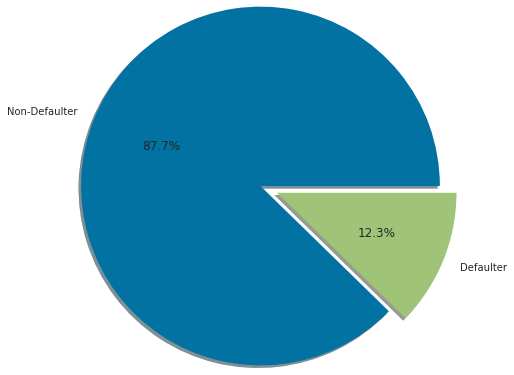

In [5]:
r = df.groupby('Risk_Flag')['Risk_Flag'].count()
plt.pie(r, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], radius=1.5, autopct='%1.1f%%',  shadow=True)
;
plt.show()


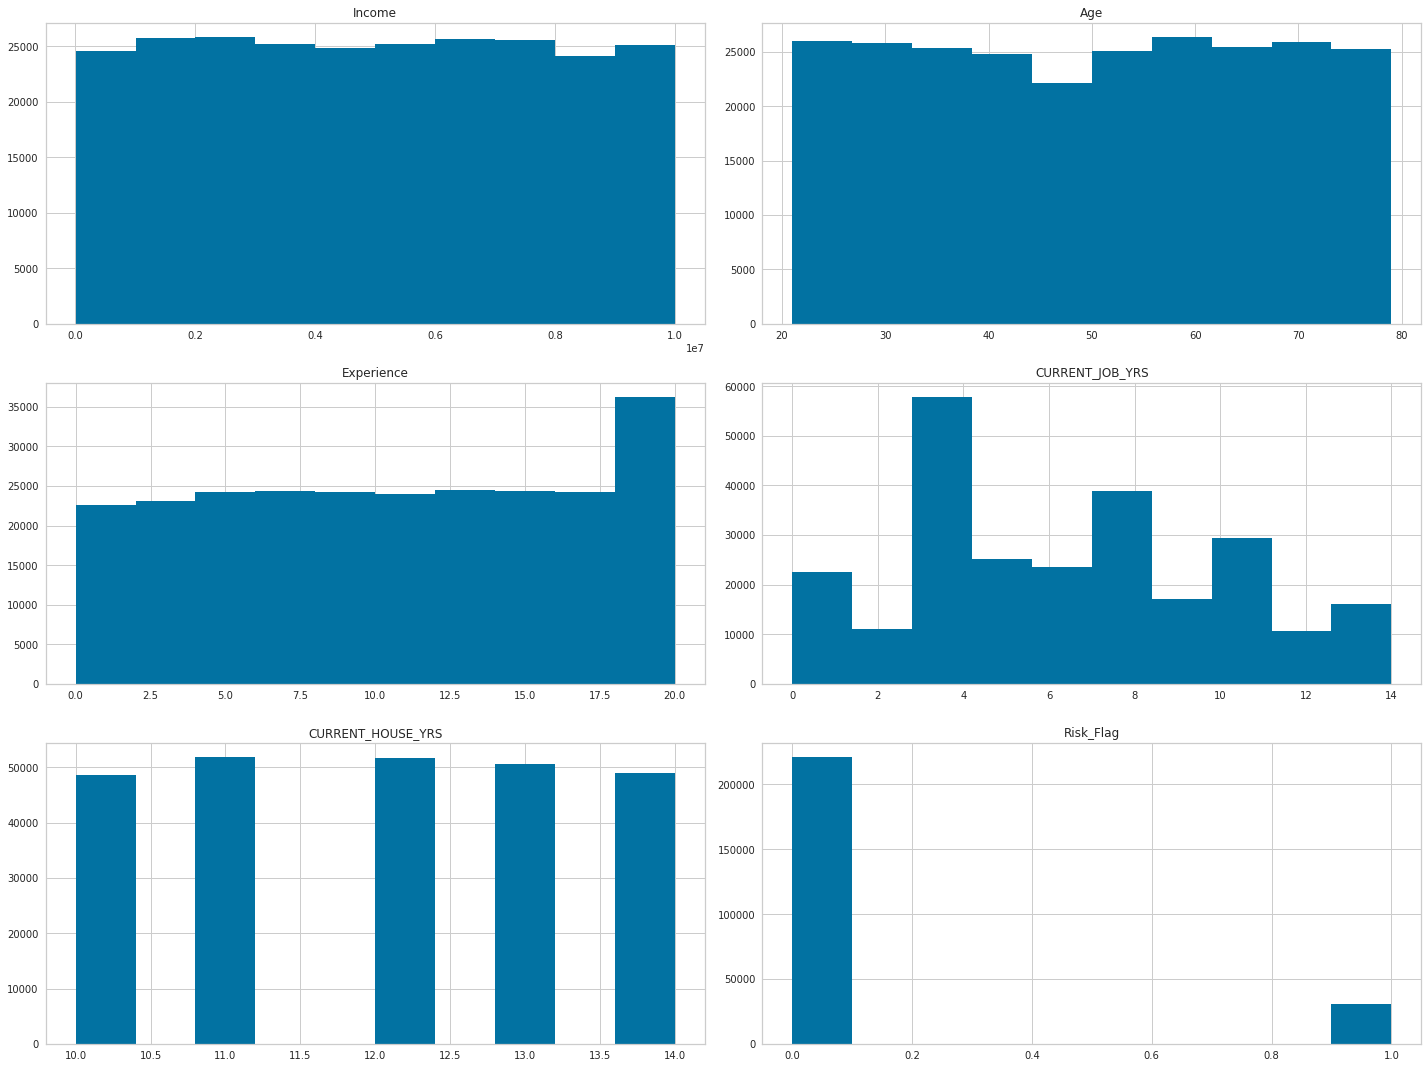

In [6]:

df.hist(figsize = (20, 15))
plt.tight_layout()


All numerical features are uniformly distributed and there's a heavy imbalance in the target class.

<AxesSubplot:>

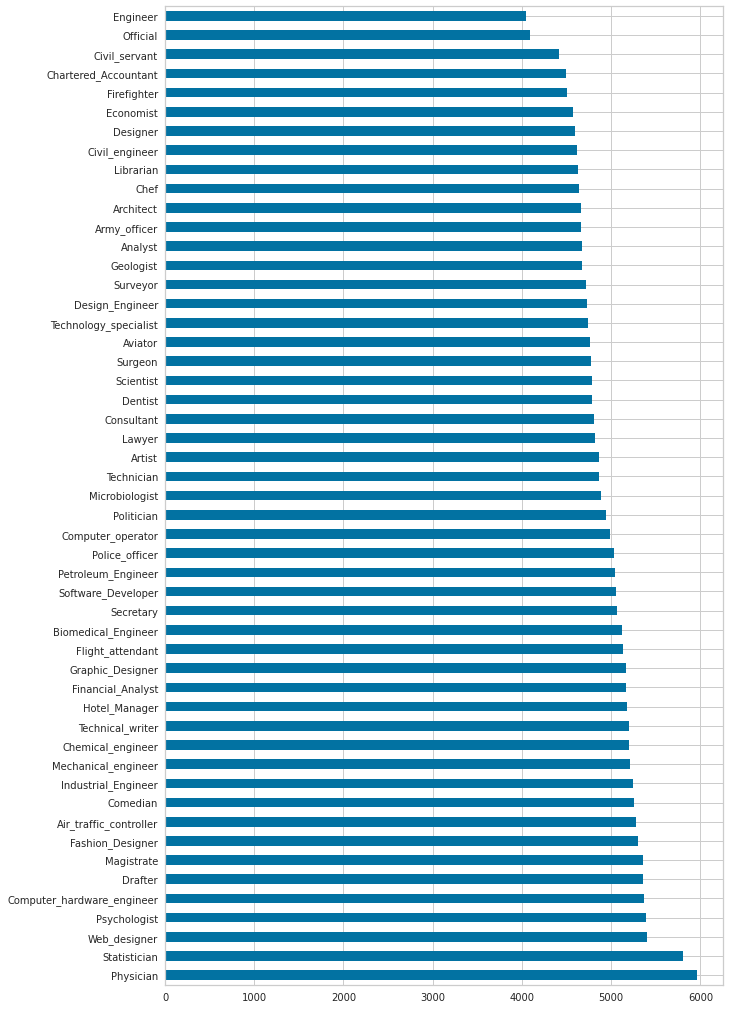

In [7]:
plt.figure(figsize=(10,18))
df['Profession'].value_counts().plot(kind='barh')




<AxesSubplot:xlabel='Risk_Flag'>

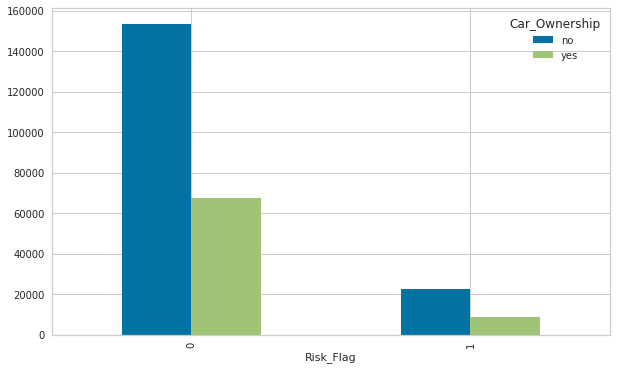

In [8]:
pd.crosstab(df.Risk_Flag,df.Car_Ownership).plot(kind= "bar",figsize = (10,6))

<AxesSubplot:xlabel='Risk_Flag'>

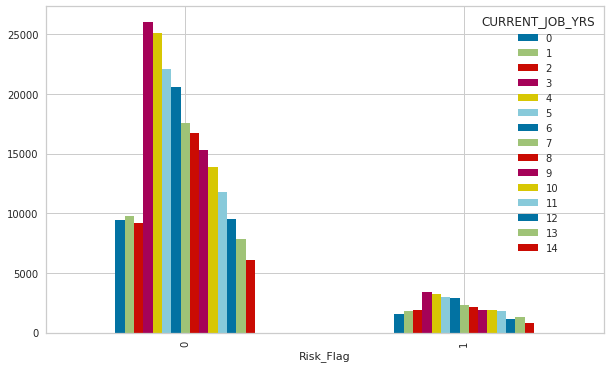

In [9]:
pd.crosstab(df.Risk_Flag,df.CURRENT_JOB_YRS).plot(kind= "bar",figsize = (10,6) )

<AxesSubplot:xlabel='Risk_Flag'>

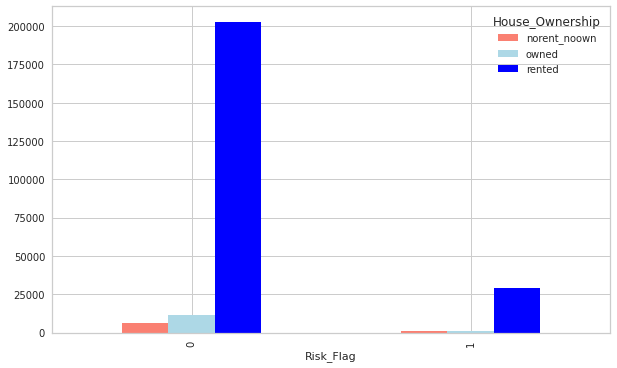

In [10]:
pd.crosstab(df.Risk_Flag,df.House_Ownership).plot(kind= "bar",figsize = (10,6) , color = ["salmon","lightblue","blue"] )

The number of defaulters is higher among those who have rented homes as can be expected in real life scenario.

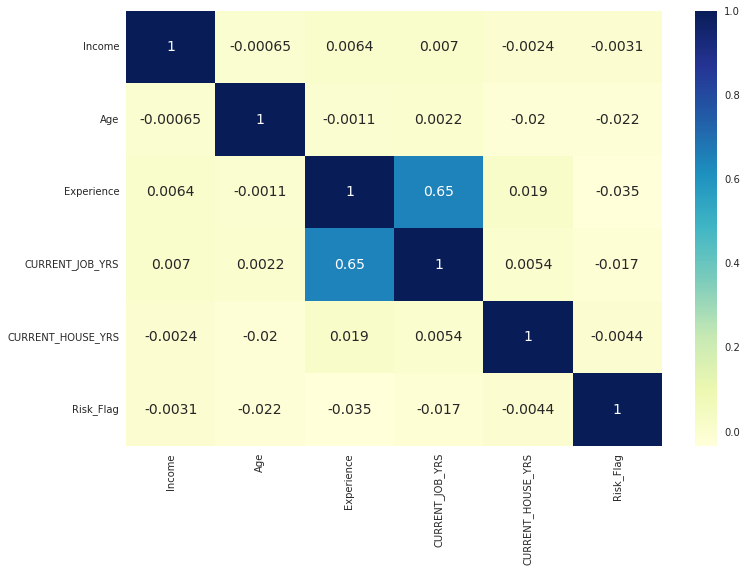

In [11]:
fig, ax = plt.subplots( figsize = (12,8) )

corr_matrix = df.corr()
corr_heatmap = sns.heatmap( corr_matrix, cmap = "YlGnBu", annot=True, ax=ax, annot_kws={"size": 14})

plt.show()

There's some collinearity between Current Job years and Experience, one of them can be removed from the data.

> **Seperating Numerical and Categorical columns**

In [12]:
cat_var = ['Married/Single','House_Ownership','Car_Ownership']
num_var = list(x_train.select_dtypes(include =['int64','float64']).columns)

y_train,y_test = np.array(y_train), np.array(y_test)
print(num_var)
print(cat_var)

['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
['Married/Single', 'House_Ownership', 'Car_Ownership']


# **Preprocessing Data**

**Numerical columns:** Scaled using MinMaxScaler


**Categorical columns:**
(i) Profession, State and City Columns were dropped because of their high cardinality
(i) Remaining columns were encoded using One hot encoding

In [13]:

preprocessor= ColumnTransformer(transformers=[('o',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_var),('s',MinMaxScaler(), num_var)], remainder='passthrough')
x_arr = preprocessor.fit_transform(x_train)
x_arr_test = preprocessor.transform(x_test)

**Visualizing preprocessed data in DataFrame**

In [14]:
new_names1 = preprocessor.transformers_[0][1].get_feature_names()
new_x = pd.DataFrame(x_arr)
new_x.rename(columns= {i:new_names1[i] for i in range(7)}, inplace=True)
new_x

,x0_married,x0_single,x1_norent_noown,x1_owned,x1_rented,x2_no,x2_yes,7,8,9,10,11
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.143242,0.586207,0.30,0.428571,0.00
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.811570,0.293103,0.05,0.071429,1.00
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.342000,0.793103,0.05,0.071429,0.50
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.102532,0.103448,0.85,0.571429,0.50
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.378861,0.517241,1.00,0.428571,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
188995,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.666301,1.000000,0.20,0.285714,0.50
188996,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.513951,0.586207,0.20,0.285714,0.75
188997,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.903086,0.482759,0.25,0.285714,0.00
188998,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.157654,0.741379,0.45,0.642857,0.00


# **Evaluating different baseline models**

Models are trained with cost-sensitive methods to account for class imbalance.

Cross validation proved to be computationally expensive for this size of dataset so a shuffled stratified split was done.

In [15]:
# def evaluate_model(X, y, model):
#     # define evaluation procedure
#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
#     # define the model evaluation metric
#     metric = make_scorer(f2_measure)
#     # evaluate model
#     scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
#     return scores
def f2_measure(y_true, y_pred): #Modified version of F1 measure for more weight on false negatives
    return fbeta_score(y_true, y_pred, beta=2)
scale_pos = count[0] / count[1] 

models = [RandomForestClassifier(class_weight='balanced', random_state=42), LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42),
KNeighborsClassifier(n_jobs=-1,weights='distance'), XGBClassifier(scale_pos_weight = scale_pos, verbosity=0, silent=True) ]
#intial cost modified base models to evaluate

model_names = ['RandomForestClassifier','LogisticRegression','KNeighborsClassifier', 'XGBClassifier' ]

for x in range(len(models)) :
    model = models[x] 
    model.fit(x_arr,y_train)
    y_pred = model.predict(x_arr_test)
    print('> %s : f2_score: %.3f , Accuracy score: %.3f , Roc_Auc_Score: %.3f' 
        %(model_names[x],f2_measure(y_test,y_pred),accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred)))


> RandomForestClassifier : f2_score: 0.713 , Accuracy score: 0.894 , Roc_Auc_Score: 0.841
> LogisticRegression : f2_score: 0.348 , Accuracy score: 0.508 , Roc_Auc_Score: 0.533
> KNeighborsClassifier : f2_score: 0.503 , Accuracy score: 0.888 , Roc_Auc_Score: 0.718


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


> XGBClassifier : f2_score: 0.654 , Accuracy score: 0.820 , Roc_Auc_Score: 0.807


As seen from the results, Baseline RandomForestClassifier model does a better job than other models with higher f2_score and roc_auc_score of 0.713 and 0.841 respectively.

# **Resampling Data for target class balancing**

To Undersample majority class (i.e class 0) : **RandomUnderSampler**

To Oversample majority class (i.e class 0) : **SMOTE (Synthetic Minority Over-sampling technique)**

No. of samples after Under-Sampling: (69741,)


<AxesSubplot:ylabel='count'>

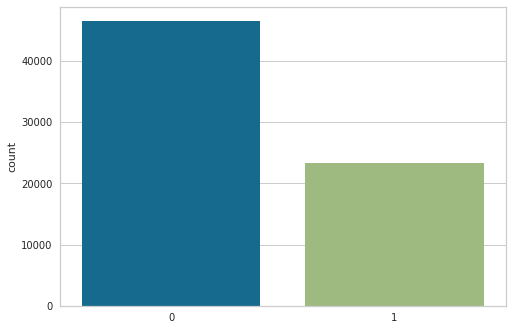

In [16]:
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
x_arr,y_train=under_sampler.fit_resample(x_arr,y_train)

print("No. of samples after Under-Sampling:",y_train.shape)
sns.countplot(x = y_train)


No. of samples after Over-Sampling: (92988,)


<AxesSubplot:ylabel='count'>

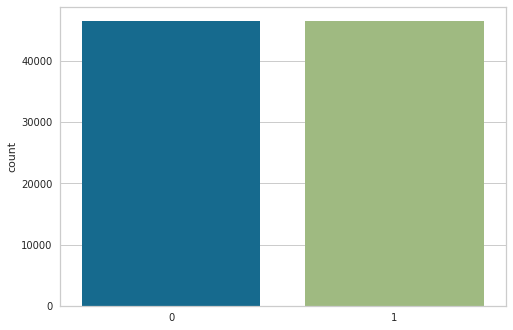

In [17]:
over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=1)
x_arr,y_train = over_sampler.fit_resample(x_arr,y_train)
print("No. of samples after Over-Sampling:",y_train.shape)
sns.countplot(x = y_train)


> **Evaluation after resampling**

In [18]:
model = RandomForestClassifier(n_jobs=-1, random_state=42,class_weight='balanced')
model.fit(x_arr,y_train)
print("Fitting done")
y_pred = model.predict(x_arr_test)
print('> %s : f2_score: %.3f , Accuracy score: %.3f , Roc_Auc_Score: %.3f ' %('Resampled_result',f2_measure(y_test,y_pred),accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred)))


Fitting done
> Resampled_result : f2_score: 0.726 , Accuracy score: 0.875 , Roc_Auc_Score: 0.852 


# **Hyperparameter tuning using 3 fold RandomSearchCV**

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [20]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 3, verbose=True, random_state=42, n_jobs = -1)
rf_random.fit(x_arr,y_train)
best_random = rf_random.best_estimator_
best_random.fit(x_arr,y_train)
print("Fitting done")
print(rf_random.best_params_)
y_pred = best_random.predict(x_arr_test)
print('> %s , f2_score: %.3f , Accuracy score: %.3f , Roc_Auc_Score: %.3f ' %('Random_search_result',f2_measure(y_test,y_pred),accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred)))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 18.2min finished


Fitting done
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
> Random_search_result , f2_score: 0.726 , Accuracy score: 0.874 , Roc_Auc_Score: 0.852 


Random_search_result , f2_score: 0.724 , Accuracy score: 0.873 , Roc_Auc_Score: 0.851  

There is hardly any improvement in the results after random search, one of the reasons could be the loss of data because of resampling 
but if the data samples were higher in number than it would be computationally very expensive to find optimal hyperparameters using RandomSearchCV.

# **Configuring Final Pipeline for analysis**

In [21]:
def load_data(file_path):
    data=pd.read_csv(file_path,index_col='Id')
    for train_index, test_index in sss.split(df,df["Risk_Flag"]):
        sss_train = df.iloc[train_index]
        sss_test = df.iloc[test_index]
    X_train= sss_train.drop(['Risk_Flag','Profession','STATE','CITY'], axis=1)
    X_val= sss_test.drop(['Risk_Flag','Profession','STATE','CITY'], axis=1)
    Y_train = sss_train.Risk_Flag
    Y_val = sss_test.Risk_Flag
    return X_train,X_val,Y_train,Y_val

X_train,X_val,Y_train,Y_val  = load_data('/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv')
Y_train,Y_val = np.array(Y_train), np.array(Y_val)

final_model = RandomForestClassifier(n_estimators= 400, min_samples_split= 10, min_samples_leaf= 1, max_features='sqrt',
                                     class_weight='balanced',n_jobs=-1,random_state=42,max_depth= 60, bootstrap=False)
config =[('pre',preprocessor),('u',under_sampler),('o',over_sampler),('m',final_model)]
pipeline = Pipeline(steps=config)
pipeline.fit(X_train,Y_train)
Y_pred = pipeline.predict(X_val)

print('> %s : f2_score: %.3f , Accuracy score: %.3f , Roc_Auc_Score: %.3f ' 
      %('Final_evaluation_score',f2_measure(Y_val,Y_pred),accuracy_score(Y_val,Y_pred),roc_auc_score(Y_val,Y_pred)))


> Final_evaluation_score : f2_score: 0.726 , Accuracy score: 0.874 , Roc_Auc_Score: 0.852 


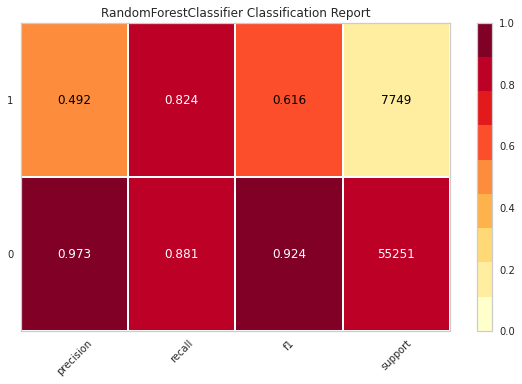

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [22]:
classes = ["0", "1"]
visualizer = ClassificationReport(pipeline, classes=classes, support=True)
visualizer.fit(X_train, Y_train)        # Fit the visualizer and the model
visualizer.score(X_val, Y_val)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure



Text(0.5, 1.0, 'Confusion  Matrix')

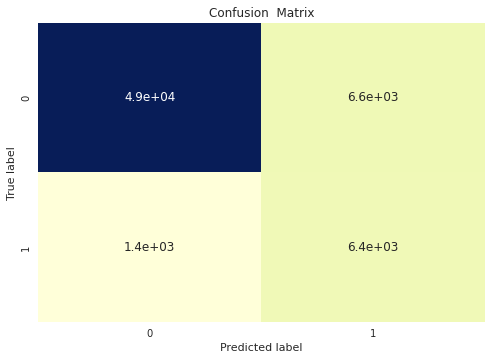

In [23]:
#Visualizing confusion matrix using seaborn
sns.heatmap(confusion_matrix(Y_val,Y_pred),annot=True,cbar=False,cmap= 'YlGnBu')
plt.xlabel("Predicted label") # predictions go on the x-axis
plt.ylabel("True label") # true labels go on the y-axis 
plt.title("Confusion  Matrix")

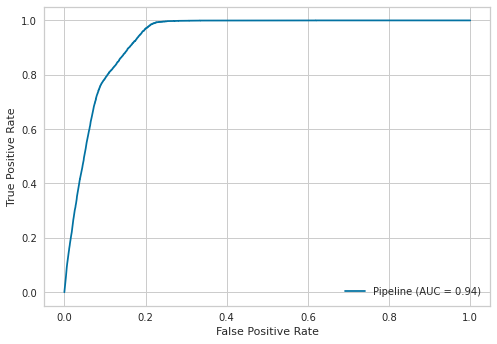

In [24]:
plot_roc_curve(pipeline,X_val,Y_val)

**Submission of Test Results**

In [25]:
test_data=pd.read_csv('/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv', index_col='ID')
test_data = test_data.drop(['Profession','STATE','CITY'], axis=1)
y_final = pipeline.predict(test_data)
my_submission = pd.DataFrame({'id': test_data.index, 'risk_flag': y_final})
my_submission.to_csv('submission.csv', index=False)